In [ ]:
!pip install pandas
!pip install statsmodels


In [81]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from statsmodels.tools.tools import add_constant
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
from google.colab import drive
pd.set_option('display.float_format', lambda x: '%.3f' % x)
drive.mount('/content/drive')

Mounted at /content/drive


In [82]:
data = pd.read_stata('/content/drive/MyDrive/econometrics/macrodat.dta')

In [83]:
data.head(5)

,UR,CPI,FFIR,TBILL,TBON,ER,GDP,date
0,5.833,28.993,2.800,2.800,3.610,281.271,14.319,1959-01-01
1,5.100,29.043,3.390,3.210,4.070,281.254,14.803,1959-04-01
2,5.267,29.193,3.760,4.040,5.000,280.370,15.576,1959-07-01
3,5.600,29.370,3.990,4.490,5.140,279.845,15.422,1959-10-01
4,5.133,29.397,3.840,3.310,4.020,280.586,16.513,1960-01-01


In [84]:
# prepare the data
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

In [85]:
data.head(1)

,UR,CPI,FFIR,TBILL,TBON,ER,GDP
date,,,,,,,
1959-01-01,5.833,28.993,2.800,2.800,3.610,281.271,14.319


In [86]:
# Function to test stationarity
def test_stationarity(series, title):
    result = adfuller(series.dropna())
    print(f'Augmented Dickey-Fuller Test for {title}')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    print('\n')

In [87]:
# Let's use GDP as dependent variable and other variables as independent
# First, let's check stationarity of GDP
print("Testing stationarity of variables:")
test_stationarity(data['GDP'], 'GDP')

Testing stationarity of variables:
Augmented Dickey-Fuller Test for GDP
ADF Statistic: -0.7912897609831264
p-value: 0.8216672543464356
Critical values:
	1%: -3.474120870218417
	5%: -2.880749791423677
	10%: -2.5770126333102494




In [88]:
# Create first differences of variables to achieve stationarity
data['GDP_diff'] = data['GDP'].diff()
data['CPI_diff'] = data['CPI'].diff()
data['FFIR_diff'] = data['FFIR'].diff()
data['TBILL_diff'] = data['TBILL'].diff()
data['TBON_diff'] = data['TBON'].diff()
data['ER_diff'] = data['ER'].diff()
data['UR_diff'] = data['UR'].diff()

In [89]:
# Remove NaN values created by differencing
data_diff = data.dropna()

In [90]:
# Create the initial model
X = data_diff[['CPI_diff', 'FFIR_diff', 'TBILL_diff', 'TBON_diff', 'ER_diff', 'UR_diff']]
y = data_diff['GDP_diff']

In [91]:
# Standardize variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
# Add constant for the regression
X_with_const = add_constant(X_scaled)

In [92]:
# Fit OLS model
model = OLS(y, X_with_const).fit()
print("\nInitial Model Summary:")
print(model.summary())


Initial Model Summary:
                            OLS Regression Results                            
Dep. Variable:               GDP_diff   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.6446
Date:                Sat, 23 Nov 2024   Prob (F-statistic):              0.694
Time:                        04:01:44   Log-Likelihood:                -172.75
No. Observations:                 161   AIC:                             359.5
Df Residuals:                     154   BIC:                             381.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6341      0

In [93]:
# Test for heteroskedasticity using Breusch-Pagan test
# Create squared residuals for BP test
resid_sq = model.resid ** 2

# Regression for BP test
bp_model = OLS(resid_sq, X_with_const).fit()
bp_test_stat = bp_model.nobs * bp_model.rsquared

print("\nBreusch-Pagan test for heteroskedasticity:")
print(f"Test statistic: {bp_test_stat}")
from scipy import stats
bp_p_value = 1 - stats.chi2.cdf(bp_test_stat, X_with_const.shape[1] - 1)
print(f"P-value: {bp_p_value}")

# If heteroskedasticity is present (p < 0.05), use robust standard errors
if bp_p_value < 0.05:
    print("\nHeteroskedasticity detected, using robust standard errors")
    robust_se = model.get_robustcov_results(cov_type='HC3').bse
    print("\nRobust Standard Errors:")
    for name, se in zip(X_with_const.columns, robust_se):
        print(f"{name}: {se:.4f}")


Breusch-Pagan test for heteroskedasticity:
Test statistic: 1.667691226455648
P-value: 0.9475882061363464


In [94]:
# Test for serial correlation
bg_test = acorr_breusch_godfrey(model, nlags=4)
print("\nBreusch-Godfrey test for serial correlation:")
print(f"LM statistic: {bg_test[0]}")
print(f"LM test p-value: {bg_test[1]}")
print(f"F statistic: {bg_test[2]}")
print(f"F test p-value: {bg_test[3]}")


Breusch-Godfrey test for serial correlation:
LM statistic: 18.33355406803747
LM test p-value: 0.0010619464477011425
F statistic: 4.818990709835694
F test p-value: 0.001100949742842404


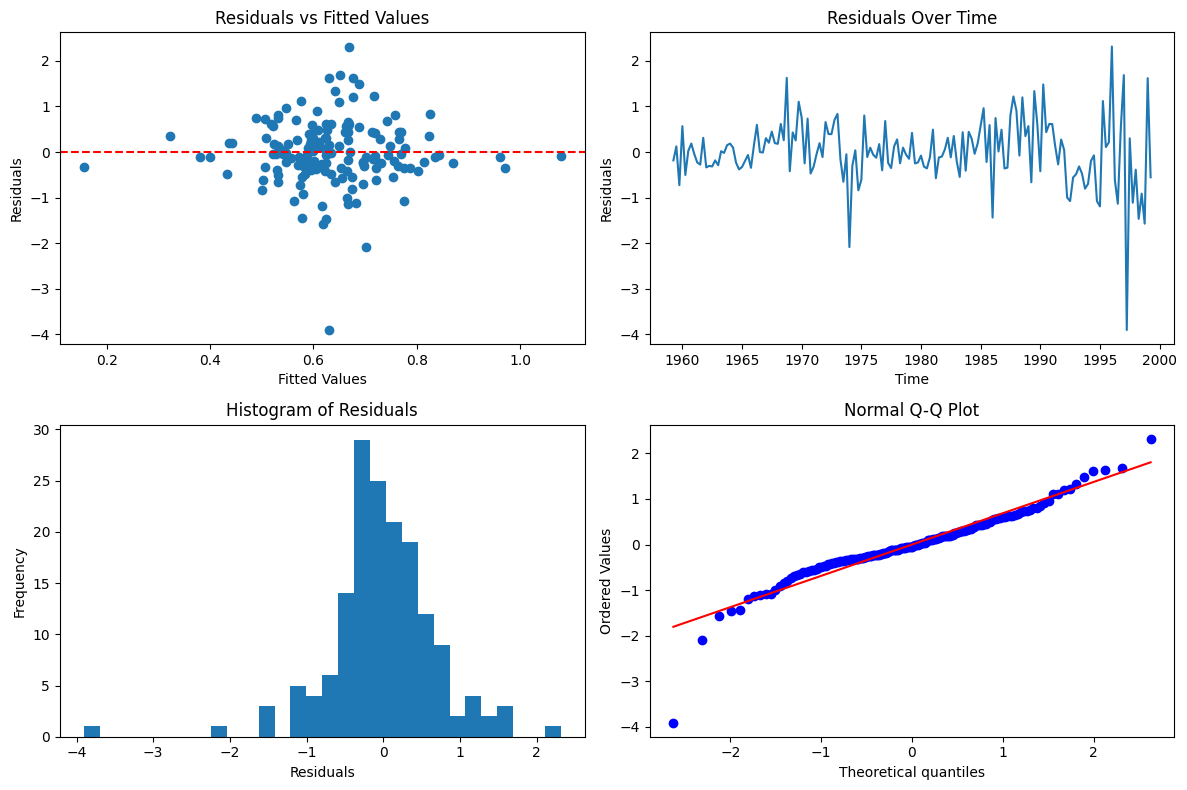

In [95]:
# Visualization
plt.figure(figsize=(12, 8))

# Plot 1: Residuals vs Fitted
plt.subplot(221)
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')

# Plot 2: Time series of residuals
plt.subplot(222)
plt.plot(model.resid)
plt.title('Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residuals')

# Plot 3: Residuals histogram
plt.subplot(223)
plt.hist(model.resid, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Plot 4: Q-Q plot
plt.subplot(224)
from scipy import stats
stats.probplot(model.resid, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')

plt.tight_layout()
plt.show()

In [96]:
# Method 1: SARIMAX with corrected specification
print("Method 1: SARIMAX Model with Corrected Specification")
sarimax_model = SARIMAX(y,
                       X_scaled,
                       order=(3, 0, 0),  # AR(3) for non-seasonal
                       seasonal_order=(1, 0, 0, 4),  # Seasonal AR(1) with period=4
                       enforce_stationarity=True)
results_sarimax = sarimax_model.fit()
print("\nSARIMAX Model Summary:")
print(results_sarimax.summary())

Method 1: SARIMAX Model with Corrected Specification


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)



SARIMAX Model Summary:
                                     SARIMAX Results                                     
Dep. Variable:                          GDP_diff   No. Observations:                  161
Model:             SARIMAX(3, 0, 0)x(1, 0, 0, 4)   Log Likelihood                -171.202
Date:                           Sat, 23 Nov 2024   AIC                            364.403
Time:                                   04:02:01   BIC                            398.299
Sample:                               04-01-1959   HQIC                           378.166
                                    - 04-01-1999                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CPI_diff      -0.0025      0.110     -0.023      0.982      -0.217       0.212
FFIR_diff     -0.06

In [ ]:
# Method 3: Extended lagged variables model
print("\nMethod 3: Extended Lagged Variables Model")
# Create lags of GDP_diff
for i in range(1, 4):  # Creating 3 lags
    data_diff[f'GDP_diff_lag{i}'] = data_diff['GDP_diff'].shift(i)

# Create seasonal lags (lag 4 for quarterly data)
data_diff['GDP_diff_lag4'] = data_diff['GDP_diff'].shift(4)

In [98]:
# Prepare new dataset with lags
data_with_lags = data_diff.dropna()
X_lags = data_with_lags[['CPI_diff', 'FFIR_diff', 'TBILL_diff', 'TBON_diff', 'ER_diff', 'UR_diff'] +
                       [f'GDP_diff_lag{i}' for i in range(1, 5)]]
y_lags = data_with_lags['GDP_diff']

# Standardize variables
X_lags_scaled = pd.DataFrame(scaler.fit_transform(X_lags), columns=X_lags.columns, index=X_lags.index)
X_lags_with_const = add_constant(X_lags_scaled)

In [99]:
# Fit model with lags
model_with_lags = OLS(y_lags, X_lags_with_const).fit()
print("\nModel with Extended Lags Summary:")
print(model_with_lags.summary())

# Test for remaining serial correlation in all models
# For SARIMAX
bg_test_sarimax = acorr_breusch_godfrey(OLS(y[4:], add_constant(results_sarimax.fittedvalues[4:])).fit(), nlags=4)
print("\nBreusch-Godfrey test for SARIMAX model:")
print(f"LM test p-value: {bg_test_sarimax[1]}")

# For lagged model
bg_test_lags = acorr_breusch_godfrey(model_with_lags, nlags=4)
print("\nBreusch-Godfrey test for lagged model:")
print(f"LM test p-value: {bg_test_lags[1]}")


Model with Extended Lags Summary:
                            OLS Regression Results                            
Dep. Variable:               GDP_diff   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     2.213
Date:                Sat, 23 Nov 2024   Prob (F-statistic):             0.0200
Time:                        04:02:02   Log-Likelihood:                -160.47
No. Observations:                 157   AIC:                             342.9
Df Residuals:                     146   BIC:                             376.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const      

In [100]:
# Compare model performance

# SARIMAX performance
sarimax_mse = mean_squared_error(y[4:], results_sarimax.fittedvalues[4:])
sarimax_r2 = r2_score(y[4:], results_sarimax.fittedvalues[4:])

# Lagged model performance
lagged_mse = mean_squared_error(y_lags, model_with_lags.fittedvalues)
lagged_r2 = r2_score(y_lags, model_with_lags.fittedvalues)

In [101]:
print("\nModel Comparison:")
print(f"SARIMAX Model - MSE: {sarimax_mse:.4f}, R2: {sarimax_r2:.4f}")
print(f"Lagged Model - MSE: {lagged_mse:.4f}, R2: {lagged_r2:.4f}")


Model Comparison:
SARIMAX Model - MSE: 0.4920, R2: 0.0551
Lagged Model - MSE: 0.4522, R2: 0.1316


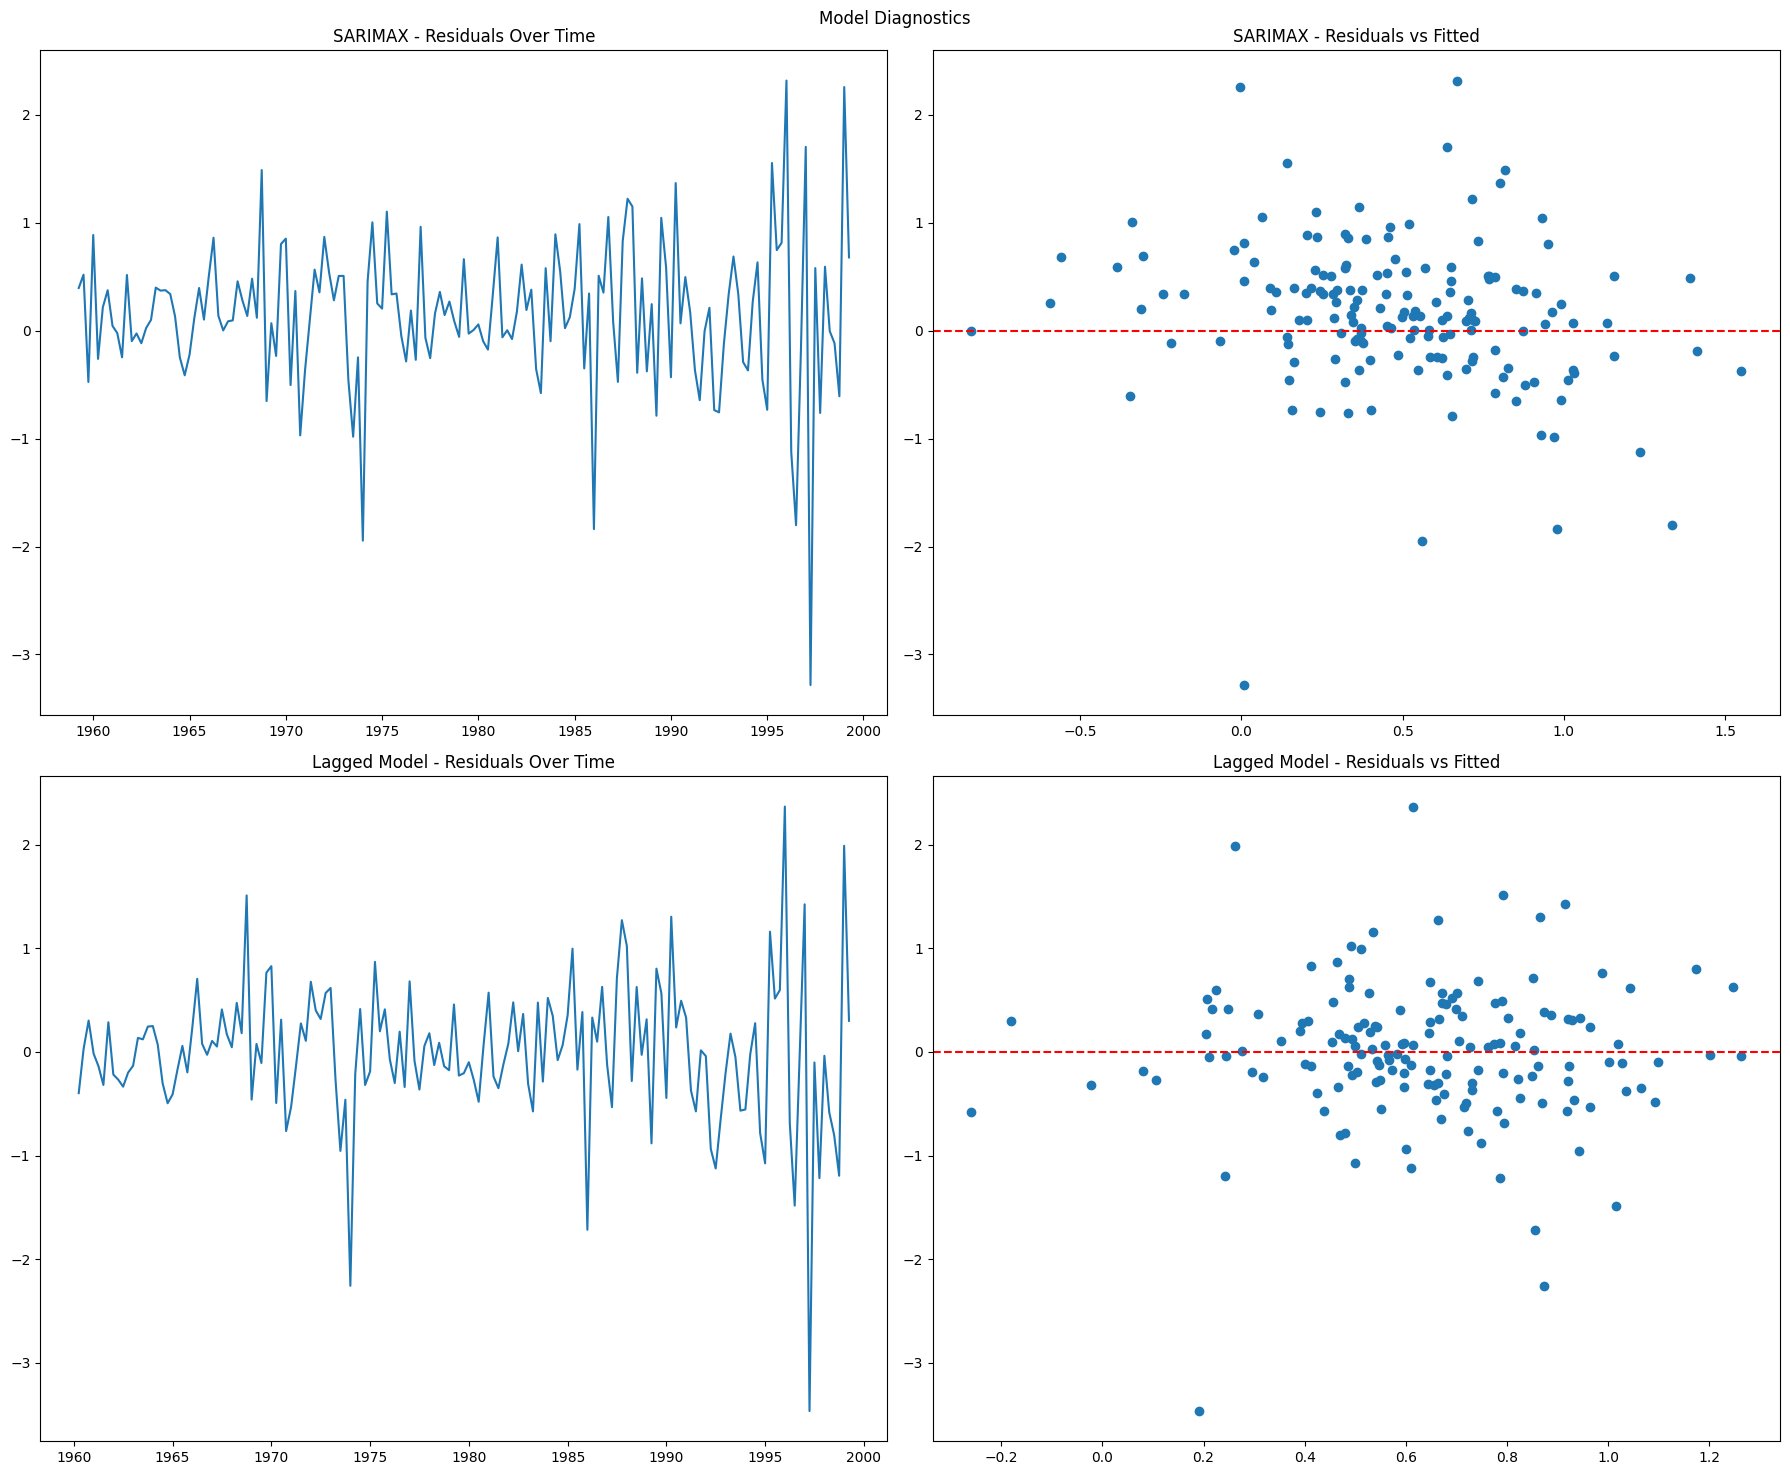

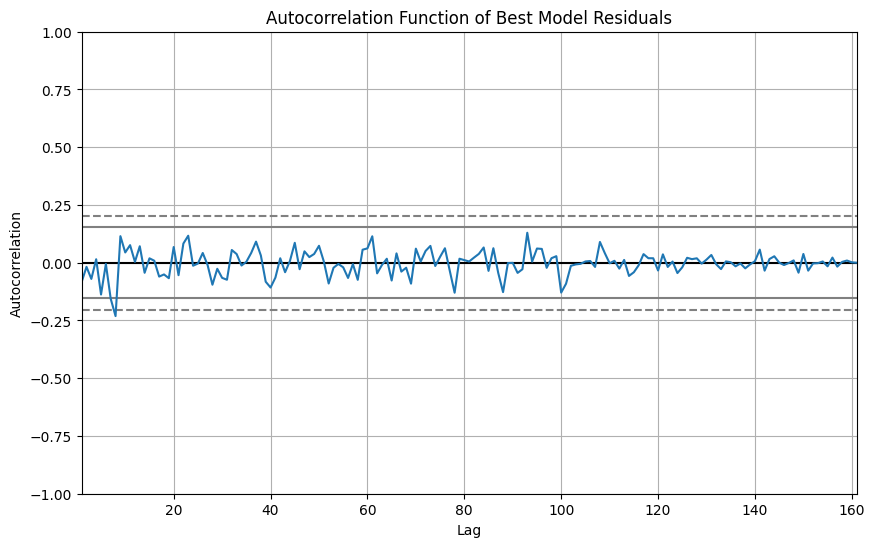

In [110]:
# Plot diagnostics for all models
fig, axes = plt.subplots(2, 2, figsize=(18, 15))
fig.suptitle('Model Diagnostics')

# SARIMAX diagnostics
axes[0,0].plot(results_sarimax.resid)
axes[0,0].set_title('SARIMAX - Residuals Over Time')
axes[0,1].scatter(results_sarimax.fittedvalues, results_sarimax.resid)
axes[0,1].set_title('SARIMAX - Residuals vs Fitted')
axes[0,1].axhline(y=0, color='r', linestyle='--')

# Lagged model diagnostics
axes[1,0].plot(model_with_lags.resid)
axes[1,0].set_title('Lagged Model - Residuals Over Time')
axes[1,1].scatter(model_with_lags.fittedvalues, model_with_lags.resid)
axes[1,1].set_title('Lagged Model - Residuals vs Fitted')
axes[1,1].axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

# Plot ACF for the best performing model
plt.figure(figsize=(10, 6))
pd.plotting.autocorrelation_plot(results_sarimax.resid)
plt.title('Autocorrelation Function of Best Model Residuals')
plt.show()

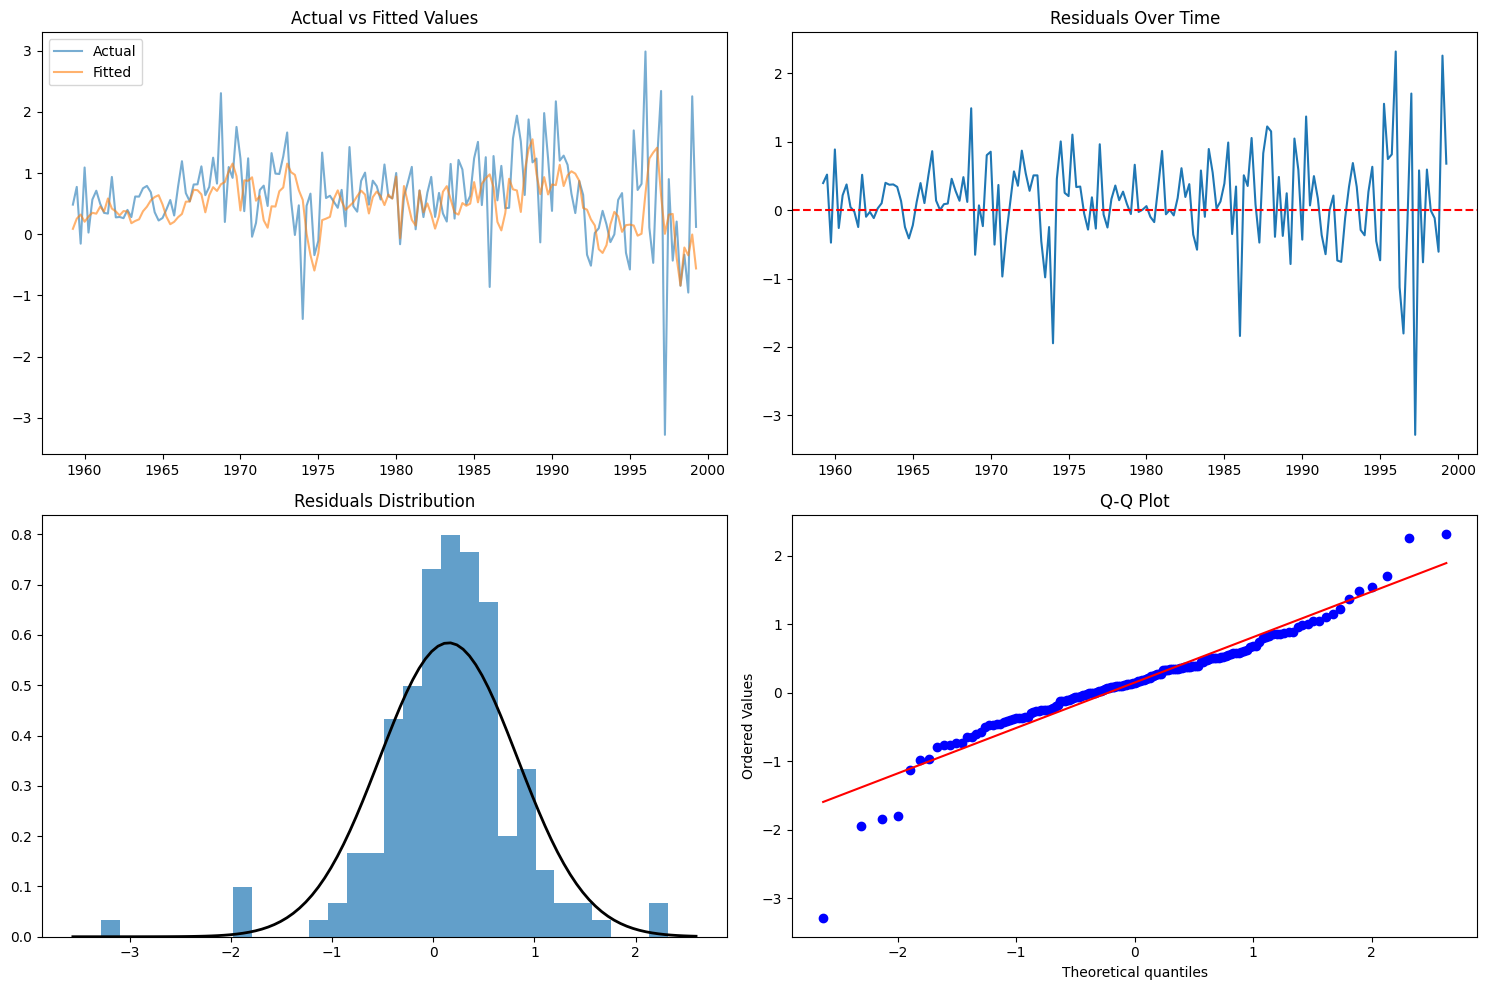

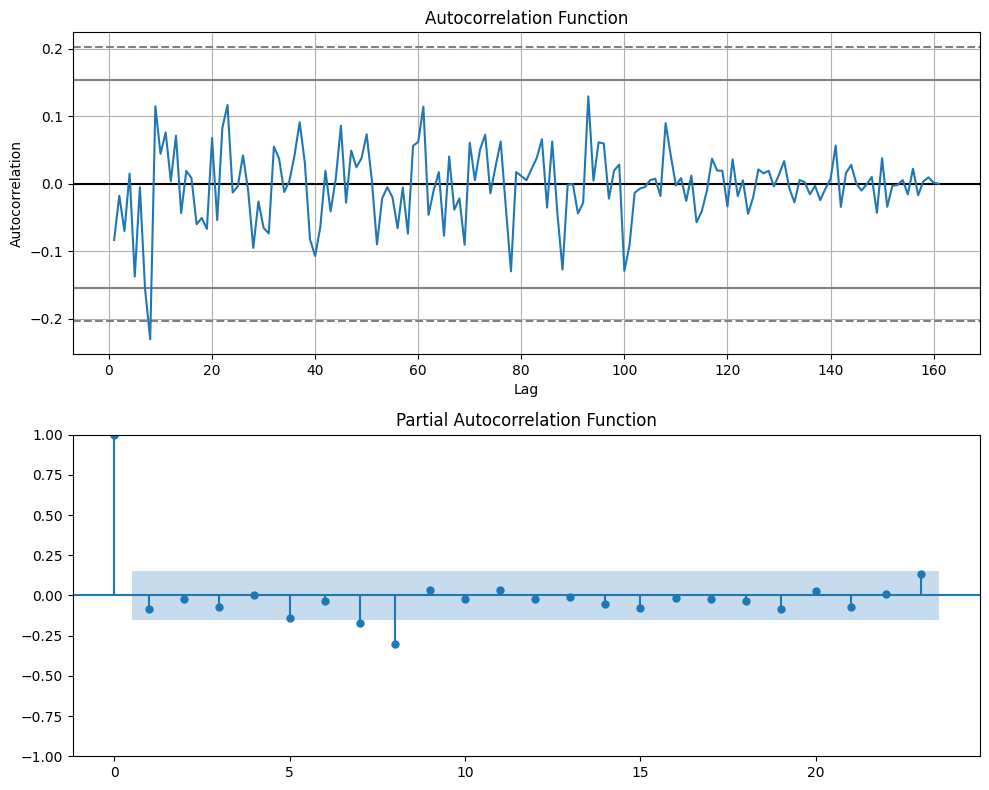

In [113]:
# Create comprehensive diagnostic plots
fig = plt.figure(figsize=(15, 10))

# 1. Actual vs Fitted Values
plt.subplot(221)
plt.plot(y, label='Actual', alpha=0.6)
plt.plot(results_sarimax.fittedvalues, label='Fitted', alpha=0.6)
plt.title('Actual vs Fitted Values')
plt.legend()

# 2. Residuals Over Time
plt.subplot(222)
plt.plot(results_sarimax.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals Over Time')

# 3. Residuals Distribution
plt.subplot(223)
plt.hist(results_sarimax.resid, bins=30, density=True, alpha=0.7)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(results_sarimax.resid), np.std(results_sarimax.resid))
plt.plot(x, p, 'k', linewidth=2)
plt.title('Residuals Distribution')

# 4. Q-Q Plot
plt.subplot(224)
stats.probplot(results_sarimax.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()

# Plot ACF/PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# ACF
pd.plotting.autocorrelation_plot(results_sarimax.resid, ax=ax1)
ax1.set_title('Autocorrelation Function')

# PACF
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(results_sarimax.resid, ax=ax2)
ax2.set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [115]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [117]:
mse = mean_squared_error(y[4:], results_sarimax.fittedvalues[4:])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y[4:], results_sarimax.fittedvalues[4:])
r2 = r2_score(y[4:], results_sarimax.fittedvalues[4:])

print("\nModel Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Print coefficient impacts
print("\nStandardized Coefficient Impacts:")
coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Coefficient': results_sarimax.params[5:],  # Skip AR terms
    'Std Error': results_sarimax.bse[5:],
    'P-value': results_sarimax.pvalues[5:]
})
print(coef_df.sort_values(by='P-value'))


Model Performance Metrics:
Mean Squared Error (MSE): 0.4920
Root Mean Squared Error (RMSE): 0.7014
Mean Absolute Error (MAE): 0.4962
R-squared (R²): 0.0551

Standardized Coefficient Impacts:
           Variable  Coefficient  Std Error  P-value
sigma2      UR_diff        0.487      0.044    0.000
ar.L3     TBON_diff        0.401      0.078    0.000
ar.S.L4     ER_diff        0.324      0.068    0.000
ar.L2    TBILL_diff        0.218      0.068    0.001
ar.L1     FFIR_diff        0.047      0.065    0.472
UR_diff    CPI_diff       -0.023      0.094    0.808
